In [1]:
import contextlib
import io

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 

pd.set_option('display.float_format', lambda x: '%.1f' % x)
np.set_printoptions(precision=2)

from scipy.interpolate import interp1d

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout, BatchNormalization, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.regularizers import l2


import joblib
import ast

2025-10-03 16:24:47.038342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 16:24:47.088521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 16:24:48.060979: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def split_dataframe(df, train_size=0.7, val_size=0.2):
    """
    Découpe un DataFrame temporel en trois parties : train, val, test,
    en respectant l'ordre chronologique.

    Args:
        df (pd.DataFrame): Données à découper (indexé ou non par le temps)
        train_size (float): Proportion pour l'ensemble d'entraînement
        val_size (float): Proportion pour la validation

    Returns:
        df_train, df_val, df_test (DataFrames)
    """
    df = df.copy()
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    print(f"Train size : {len(df_train)}")
    print(f"Val size : {len(df_val)}")
    print(f"Test size : {len(df_test)}")

    return df_train.copy(), df_val.copy(), df_test.copy()

In [3]:
def evaluate_model(y_true, y_pred):
    """
    Calcule et affiche les métriques MAE, RMSE et R² entre les vraies valeurs et les prédictions.

    Args:
        y_true (array-like): Valeurs réelles.
        y_pred (array-like): Valeurs prédites.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return {"MAE":mae, "RMSE":rmse, "R2 Score":r2}

In [4]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

    """
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
    """

In [5]:
def train_temperature_model(X, y, epochs=100, batch_size=32, validation_split=0.2):
    """
    Construit, compile et entraîne un modèle Keras pour prédire 24 températures horaires.

    Paramètres
    ----------
    X : ndarray shape (n_samples, n_features)
        Tableau des caractéristiques d’entrée (ex. Tmin, Tmoy, Tmax, jour_annee, mois).
    y : ndarray shape (n_samples, n_outputs)
        Tableau des cibles (24 températures horaires).
    epochs : int, optional (default=100)
        Nombre d’époques d’entraînement.
    batch_size : int, optional (default=32)
        Taille du batch.
    validation_split : float, optional (default=0.2)
        Fraction des données réservée à la validation.

    Retour
    ------
    model : keras.Model
        Le modèle entraîné.
    history : keras.callbacks.History
        L’historique d’entraînement (pertes et métriques).
    """
    input_dim  = X.shape[1]
    output_dim = y.shape[1]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(output_dim)                         # régression, donc pas d’activation finale
    ])

    model.compile(optimizer=Adam(),
                  loss='mse',
                  metrics=['mae'])

    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1)

    return model, history

In [6]:
def load_data_drias(path_fichier_excel):
    """
    Charge un fichier Excel DRIAS avec une colonne 'Date' au format '%d/%m/%Y',
    et retourne un DataFrame avec la date en index.

    Args:
        path_fichier_excel (str): Chemin vers le fichier Excel.

    Returns:
        pd.DataFrame: Données DRIAS avec l'index daté.
    """
    df = pd.read_excel(path_fichier_excel)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    display(df)
    
    return df

In [7]:
def predict_and_inverse_transform(model, X, y, target_transformer):
    """
    Effectue la prédiction avec le modèle donné et applique l'inverse de la transformation 
    sur les prédictions et les vraies valeurs cibles.

    Args:
        model: Modèle entraîné (ex. BiLSTM).
        X_val: Données d'entrée de validation.
        y_val: Vraies valeurs cibles de validation.
        target_transformer: Transformateur utilisé pour normaliser les cibles (ex. MinMaxScaler).

    Returns:
        Tuple (y_pred_original_scale, y_true_original_scale)
    """
    # Prédiction
    y_pred = model.predict(X)

    # Inversion de la transformation des prédictions
    y_pred_inv = target_transformer.inverse_transform(y_pred)

    # Reshape puis inversion de la transformation des vraies valeurs
    y = y.reshape(-1, 1)
    y_val_inv = target_transformer.inverse_transform(y)

    return y_pred_inv, y_val_inv

In [8]:
def convertir_q_en_rh(q_kgkg, temperature_C, pression_hPa=1013.25):
    """
    Convertit une série d'humidité spécifique (kg/kg) et de température (°C)
    en humidité relative (%) en supposant une pression constante.

    Paramètres :
        q_kgkg : pd.Series ou np.array d'humidité spécifique (kg/kg)
        temperature_C : pd.Series ou np.array de température (°C)
        pression_hPa : pression atmosphérique en hPa (par défaut = 1013.25)

    Retour :
        pd.Series ou np.array d'humidité relative (%) — même type que l'entrée
    """
    q = np.asarray(q_kgkg)
    T = np.asarray(temperature_C)

    # Pression partielle de vapeur d'eau (e) [hPa]
    e = (q * pression_hPa) / (0.622 + 0.378 * q)

    # Pression de vapeur saturante (e_s) [hPa] — formule de Tetens
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))

    # Humidité relative RH [%]
    RH = 100 * e / e_s
    RH = np.clip(RH, 0, 100)

    # Renvoyer dans le même format que l'entrée
    if isinstance(q_kgkg, pd.Series):
        return pd.Series(RH, index=q_kgkg.index, name='RH_%')
    else:
        return RH
    
    
def calculate_relative_humidity(tmean, huss):
    """
    Calcule l'humidité relative (hr) en % à partir des données :
    - tasmin : température minimale journalière à 2m (°C)
    - tasmax : température maximale journalière à 2m (°C)
    - huss   : humidité spécifique à 2m (g/kg)

    Toutes les entrées peuvent être scalaires, des tableaux NumPy ou des colonnes pandas.
    """

    # 2. Pression de vapeur de saturation psat (en hPa)
    psat = np.where(
        tmean < 0,
        10 ** (2.7862 + (9.7561 * tmean) / (272.67 + tmean)),
        10 ** (2.7862 + (7.5526 * tmean) / (239.21 + tmean))
    )

    # 3. Calcul de l’humidité relative en pourcentage
    hr = (huss / 0.622) / psat * 10000
    hr = np.minimum(hr, 100)  # Limiter à 100 %

    return hr

In [9]:
def convertir_humidite_kgkg_en_gkg(serie_kgkg):
    """
    Convertit une série Pandas d'humidité spécifique de kg/kg en g/kg.
    
    Paramètres :
    - serie_kgkg : pd.Series contenant des valeurs en kg/kg
    
    Retour :
    - pd.Series contenant les valeurs converties en g/kg
    """
    return serie_kgkg * 1000

In [10]:
def extract_24h_values(group):
    if len(group) == 24:
        return group.values
    else:
        print(group)

##### **Dataset DRIAS RCP**

In [11]:
data_rcp_2_6 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.0,0.0,0.0,0.0,53.7,265.0,2.2,0.2
2006-01-02,49.2,4.0,0.2,4.0,2.1,8.8,1.0,0.0,9.2,344.0,7.1,0.1
2006-01-03,49.2,4.0,8.6,9.2,9.0,0.7,0.0,0.0,7.5,382.9,8.3,0.2
2006-01-04,49.2,4.0,9.9,14.2,12.7,0.5,0.0,0.0,19.2,356.6,5.4,0.4
2006-01-05,49.2,4.0,7.6,11.5,9.0,0.0,0.0,0.0,14.2,367.9,2.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,0.7,4.6,2.6,0.0,0.0,0.0,53.9,263.4,3.4,0.6
2100-12-28,49.2,4.0,-0.7,2.5,0.7,1.0,0.6,0.0,12.9,314.8,3.8,0.4
2100-12-29,49.2,4.0,-1.1,1.2,-0.2,0.4,0.4,0.0,18.2,310.8,1.2,0.2


In [12]:
data_rcp_4_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.7,-0.0,0.2,0.2,3.5,53.2,264.9,7.7,0.2
2006-01-02,49.2,4.0,0.0,4.1,2.0,8.4,1.0,5.0,9.1,347.3,25.2,0.0
2006-01-03,49.2,4.0,8.6,9.0,8.8,0.7,0.0,8.2,8.8,381.7,30.1,0.2
2006-01-04,49.2,4.0,9.8,13.1,11.9,0.1,0.0,7.8,16.8,355.5,20.9,0.5
2006-01-05,49.2,4.0,5.2,11.0,7.2,0.0,0.0,6.1,29.1,338.0,5.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,1.0,9.5,4.5,0.0,0.0,5.0,51.6,286.6,11.4,0.2
2100-12-28,49.2,4.0,4.1,12.0,8.3,3.6,0.0,5.9,38.1,319.0,14.5,0.4
2100-12-29,49.2,4.0,4.6,9.6,8.1,2.7,0.0,5.2,30.5,324.1,15.7,0.6


In [13]:
data_rcp_8_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp8.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.1,0.0,0.0,3.5,53.7,264.9,7.9,0.2
2006-01-02,49.2,4.0,0.1,4.0,2.0,8.6,1.1,5.0,9.5,344.4,25.1,0.0
2006-01-03,49.2,4.0,8.6,8.9,8.7,0.7,0.0,8.2,8.2,381.6,30.0,0.2
2006-01-04,49.2,4.0,9.8,12.3,11.4,0.1,0.0,8.0,16.0,357.1,21.4,0.2
2006-01-05,49.2,4.0,7.1,10.8,8.4,0.0,0.0,6.5,13.6,365.0,7.5,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,-0.7,6.1,1.6,0.1,0.0,3.1,51.8,285.6,7.6,0.5
2100-12-28,49.2,4.0,1.8,4.4,3.0,0.3,0.0,4.7,21.3,340.2,1.7,0.1
2100-12-29,49.2,4.0,2.2,6.7,5.2,0.5,0.1,4.9,17.4,343.0,9.0,0.2


##### **Dataset Prunay**
🌦️ Description des colonnes - Station météo Reims - Prunay

In [14]:
data_prunay = pd.read_csv('Atmo/reims_hourly_2007_2025.csv')
data_prunay

,time,temperature_2m,relative_humidity_2m,pressure_msl,precipitation,wind_speed_10m
0,2007-01-01 00:00:00,11.8,91.0,1019.5,1.0,28.4
1,2007-01-01 01:00:00,11.7,93.0,1018.8,2.2,30.7
2,2007-01-01 02:00:00,12.0,91.0,1017.8,1.4,34.6
3,2007-01-01 03:00:00,12.3,90.0,1017.6,0.4,35.4
4,2007-01-01 04:00:00,12.3,90.0,1017.6,0.6,32.2
...,...,...,...,...,...,...
162643,2025-07-21 19:00:00,NaN,NaN,NaN,NaN,NaN
162644,2025-07-21 20:00:00,NaN,NaN,NaN,NaN,NaN
162645,2025-07-21 21:00:00,NaN,NaN,NaN,NaN,NaN
162646,2025-07-21 22:00:00,NaN,NaN,NaN,NaN,NaN


In [15]:
data_prunay['time'] = pd.to_datetime(data_prunay['time'], format='%Y-%m-%d %H:%M:%S')
data_prunay.set_index('time', inplace=True)
data_prunay

,temperature_2m,relative_humidity_2m,pressure_msl,precipitation,wind_speed_10m
time,,,,,
2007-01-01 00:00:00,11.8,91.0,1019.5,1.0,28.4
2007-01-01 01:00:00,11.7,93.0,1018.8,2.2,30.7
2007-01-01 02:00:00,12.0,91.0,1017.8,1.4,34.6
2007-01-01 03:00:00,12.3,90.0,1017.6,0.4,35.4
2007-01-01 04:00:00,12.3,90.0,1017.6,0.6,32.2
...,...,...,...,...,...
2025-07-21 19:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-21 20:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-21 21:00:00,NaN,NaN,NaN,NaN,NaN


In [16]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_prunay.index)
data_rcp_2_6_ = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [17]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_prunay.index)
data_rcp_4_5_ = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [18]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_prunay.index)
data_rcp_8_5_ = data_rcp_8_5.loc[common_index_data_rcp_8_5]

In [19]:
data_prunay = data_prunay[["temperature_2m", "relative_humidity_2m", "precipitation"]].copy()
data_prunay.rename(columns={"relative_humidity_2m": "prunay_RH"}, inplace=True)
data_prunay.rename(columns={"temperature_2m": "prunay_Temperature"}, inplace=True)
data_prunay.rename(columns={"precipitation": "prunay_Precipitation"}, inplace=True)
data_prunay = data_prunay[~data_prunay.index.duplicated(keep='first')]
data_prunay.dropna(inplace=True)
RH = convertir_q_en_rh(data_rcp_2_6["hussAdjust"], data_rcp_2_6["tasAdjust"])
data_rcp_2_6["rcp_RH"] = RH

In [20]:
data_prunay

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


In [21]:
data_prunay_hourly_predict = data_prunay.copy()

In [22]:
data_rcp_2_6

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust,rcp_RH
Date,,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.0,0.0,0.0,0.0,53.7,265.0,2.2,0.2,93.6
2006-01-02,49.2,4.0,0.2,4.0,2.1,8.8,1.0,0.0,9.2,344.0,7.1,0.1,100.0
2006-01-03,49.2,4.0,8.6,9.2,9.0,0.7,0.0,0.0,7.5,382.9,8.3,0.2,100.0
2006-01-04,49.2,4.0,9.9,14.2,12.7,0.5,0.0,0.0,19.2,356.6,5.4,0.4,90.0
2006-01-05,49.2,4.0,7.6,11.5,9.0,0.0,0.0,0.0,14.2,367.9,2.0,0.3,95.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,0.7,4.6,2.6,0.0,0.0,0.0,53.9,263.4,3.4,0.6,77.2
2100-12-28,49.2,4.0,-0.7,2.5,0.7,1.0,0.6,0.0,12.9,314.8,3.8,0.4,85.5
2100-12-29,49.2,4.0,-1.1,1.2,-0.2,0.4,0.4,0.0,18.2,310.8,1.2,0.2,95.3


In [23]:
data_prunay_hourly_predict

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


In [24]:
data_prunay_hourly_temp_predict = data_prunay_hourly_predict["prunay_Temperature"].copy()

In [25]:
data_prunay_hourly_hr_predict = data_prunay_hourly_predict.copy()

In [26]:
data_prunay_hourly_temp_predict = data_prunay_hourly_temp_predict.resample('D').agg(['min', 'mean', 'max'])

In [27]:
data_prunay_hourly_hr_predict = data_prunay_hourly_hr_predict.resample('D').agg({
    'prunay_RH': ['mean'],
    'prunay_Temperature': ['min', 'mean', 'max'],
    'prunay_Precipitation' : ['mean']
})

In [28]:
data_prunay_hourly_hr_predict.columns = ['{}_{}'.format(col[0], col[1]) for col in data_prunay_hourly_hr_predict.columns]

In [29]:
data_prunay_hourly_temp_predict["day_of_year"] = data_prunay_hourly_temp_predict.index.dayofyear
data_prunay_hourly_temp_predict["month"] = data_prunay_hourly_temp_predict.index.month
data_prunay_hourly_temp_predict["hour"] = data_prunay_hourly_temp_predict.index.hour

In [30]:
data_prunay_hourly_hr_predict["day_of_year"] = data_prunay_hourly_hr_predict.index.dayofyear
data_prunay_hourly_hr_predict["month"] = data_prunay_hourly_hr_predict.index.month
data_prunay_hourly_hr_predict["hour"] = data_prunay_hourly_hr_predict.index.hour

In [31]:
data_prunay_hourly_hr_predict

,prunay_RH_mean,prunay_Temperature_min,prunay_Temperature_mean,prunay_Temperature_max,prunay_Precipitation_mean,day_of_year,month,hour
time,,,,,,,,
2007-01-01,80.4,6.0,9.3,12.3,0.3,1,1,0
2007-01-02,86.6,4.0,5.3,6.7,0.3,2,1,0
2007-01-03,91.8,4.3,5.5,6.9,0.0,3,1,0
2007-01-04,87.0,6.7,8.1,9.8,0.1,4,1,0
2007-01-05,86.2,7.3,8.5,9.6,0.0,5,1,0
...,...,...,...,...,...,...,...,...
2025-07-17,69.7,13.7,19.9,25.4,0.0,198,7,0
2025-07-18,62.3,16.2,23.0,28.7,0.0,199,7,0
2025-07-19,64.5,18.8,22.4,27.4,0.0,200,7,0


In [32]:
data_prunay_hourly_temp_predict

,min,mean,max,day_of_year,month,hour
time,,,,,,
2007-01-01,6.0,9.3,12.3,1,1,0
2007-01-02,4.0,5.3,6.7,2,1,0
2007-01-03,4.3,5.5,6.9,3,1,0
2007-01-04,6.7,8.1,9.8,4,1,0
2007-01-05,7.3,8.5,9.6,5,1,0
...,...,...,...,...,...,...
2025-07-17,13.7,19.9,25.4,198,7,0
2025-07-18,16.2,23.0,28.7,199,7,0
2025-07-19,18.8,22.4,27.4,200,7,0


In [33]:
y_temp = data_prunay["prunay_Temperature"].resample('D').apply(extract_24h_values)

time
2025-07-21 00:00:00   17.9
2025-07-21 01:00:00   17.5
2025-07-21 02:00:00   17.3
Name: 2025-07-21 00:00:00, dtype: float64


In [34]:
y_rh = data_prunay["prunay_RH"].resample('D').apply(extract_24h_values)

time
2025-07-21 00:00:00   75.0
2025-07-21 01:00:00   75.0
2025-07-21 02:00:00   75.0
Name: 2025-07-21 00:00:00, dtype: float64


In [35]:
data_prunay_hourly_temp_predict["y"] = y_temp

In [36]:
data_prunay_hourly_hr_predict["y"] = y_rh

In [37]:
data_prunay_hourly_temp_predict.dropna(inplace=True)

In [38]:
data_prunay_hourly_hr_predict.dropna(inplace=True)

In [39]:
data_prunay_hourly_temp_predict

,min,mean,max,day_of_year,month,hour,y
time,,,,,,,
2007-01-01,6.0,9.3,12.3,1,1,0,"[11.8, 11.7, 12.0, 12.3, 12.3, 11.8, 10.9, 10...."
2007-01-02,4.0,5.3,6.7,2,1,0,"[4.9, 4.1, 4.6, 5.2, 5.1, 5.0, 4.9, 4.7, 4.4, ..."
2007-01-03,4.3,5.5,6.9,3,1,0,"[5.0, 4.9, 4.8, 4.6, 4.5, 4.5, 4.4, 4.5, 4.3, ..."
2007-01-04,6.7,8.1,9.8,4,1,0,"[6.7, 6.7, 6.7, 6.8, 6.9, 7.0, 7.0, 7.3, 7.7, ..."
2007-01-05,7.3,8.5,9.6,5,1,0,"[8.1, 7.7, 7.4, 7.4, 7.3, 7.5, 7.5, 7.6, 7.7, ..."
...,...,...,...,...,...,...,...
2025-07-16,17.3,18.5,19.7,197,7,0,"[18.6, 18.8, 19.0, 18.2, 18.2, 18.0, 17.4, 17...."
2025-07-17,13.7,19.9,25.4,198,7,0,"[16.7, 16.2, 15.7, 15.0, 14.5, 14.0, 13.7, 13...."
2025-07-18,16.2,23.0,28.7,199,7,0,"[20.2, 19.8, 19.2, 17.9, 17.9, 17.0, 16.2, 16...."


In [40]:
data_prunay_hourly_hr_predict

,prunay_RH_mean,prunay_Temperature_min,prunay_Temperature_mean,prunay_Temperature_max,prunay_Precipitation_mean,day_of_year,month,hour,y
time,,,,,,,,,
2007-01-01,80.4,6.0,9.3,12.3,0.3,1,1,0,"[91.0, 93.0, 91.0, 90.0, 90.0, 91.0, 90.0, 85...."
2007-01-02,86.6,4.0,5.3,6.7,0.3,2,1,0,"[92.0, 99.0, 98.0, 92.0, 87.0, 84.0, 82.0, 82...."
2007-01-03,91.8,4.3,5.5,6.9,0.0,3,1,0,"[90.0, 91.0, 92.0, 94.0, 94.0, 94.0, 95.0, 95...."
2007-01-04,87.0,6.7,8.1,9.8,0.1,4,1,0,"[89.0, 89.0, 89.0, 88.0, 87.0, 88.0, 92.0, 94...."
2007-01-05,86.2,7.3,8.5,9.6,0.0,5,1,0,"[83.0, 85.0, 86.0, 87.0, 87.0, 87.0, 87.0, 88...."
...,...,...,...,...,...,...,...,...,...
2025-07-16,74.8,17.3,18.5,19.7,0.2,197,7,0,"[58.0, 55.0, 53.0, 59.0, 60.0, 66.0, 74.0, 77...."
2025-07-17,69.7,13.7,19.9,25.4,0.0,198,7,0,"[86.0, 84.0, 83.0, 86.0, 89.0, 90.0, 92.0, 92...."
2025-07-18,62.3,16.2,23.0,28.7,0.0,199,7,0,"[80.0, 80.0, 81.0, 84.0, 83.0, 88.0, 91.0, 90...."


In [41]:
def preprocess_data(df, features, pred):
    # Transformation cyclique pour les caractéristiques temporelles
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Cible - conversion en matrice 2D (n_jours × 24_heures)
    y = np.vstack(df['y'].values)
    
    # Normalisation
    if pred == "temp":
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
    if pred == "hr":
        X_scaler = StandardScaler()
        y_scaler = MinMaxScaler()
        
    X = X_scaler.fit_transform(df[features])
    y = y_scaler.fit_transform(y)
    
    return X, y, X_scaler, y_scaler, features

In [42]:
class TanhRange(Layer):
    def __init__(self, min_val=0, max_val=100, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
    
    def call(self, inputs):
        tanh = tf.tanh(inputs)  # [-1, 1]
        scaled = (tanh + 1) / 2  # [0, 1]
        return scaled * (self.max_val - self.min_val) + self.min_val
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "min_val": self.min_val,
            "max_val": self.max_val
        })
        return config


def build_model(input_dim, pred):
    model = Sequential([
        Dense(256, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001),
              input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        Dense(24),  # 24 sorties pour les données horaires
    ])
    
    if pred=="hr":
        model.add(TanhRange(min_val=0, max_val=100)) # Couche personnalisée ajoutée ici
    
    optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    model.summary()
    return model

In [43]:
# Entraînement avec validation temporelle
def train_model(X, y, pred):
    # Séparation temporelle (plus adaptée pour les données chronologiques)
    tscv = TimeSeriesSplit(n_splits=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"\nEntraînement fold {fold+1}/{tscv.get_n_splits()}")
        print(f"Taille train: {len(train_index)}, validation: {len(val_index)}")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = build_model(X.shape[1], pred)
        
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=16,
            callbacks=callbacks,
            verbose=1
        )
        
        # Sauvegarder le meilleur modèle
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            print(f"Nouveau meilleur modèle avec val_loss = {val_loss:.4f}")
    
    return best_model

In [44]:
def evaluate_model(model, X_test, y_test, y_scaler, pred):
    # Dénormalisation
    y_test_actual = y_scaler.inverse_transform(y_test)
    y_pred = y_scaler.inverse_transform(model.predict(X_test))
    
    # Calcul MAE par heure
    hourly_mae = np.mean(np.abs(y_pred - y_test_actual), axis=0)
    
    # Visualisation
    plt.figure(figsize=(14, 6))
    
    # MAE par heure
    plt.subplot(1, 2, 1)
    plt.bar(range(24), hourly_mae, color='skyblue')
    plt.title('Mean Absolute Error (MAE) per hour')
    plt.xlabel('Hour of the day')
    plt.ylabel('MAE')
    plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
    plt.grid(alpha=0.3)
    
    # Comparaison sur un échantillon
    sample_idx = np.random.randint(len(X_test))
    plt.subplot(1, 2, 2)
    plt.plot(y_test_actual[sample_idx], 'o-', label='true value', linewidth=2)
    plt.plot(y_pred[sample_idx], 's-', label='Prediction', linewidth=1.5)
    plt.title(f'Prediction vs True value - Random Day')
    plt.xlabel('Hours')
    plt.ylabel("Temp (°C)" if pred == "temp" else "HR (%)")
    plt.legend()
    plt.xticks(range(0, 24, 3), [f'{h:02d}h' for h in range(0, 24, 3)])
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300)
    plt.show()
    
    if pred == "temp":
        print(f"\nModel performance:")
        print(f"Mean MAE: {np.mean(hourly_mae):.4f}°C")
        print(f"Max MAE (at {np.argmax(hourly_mae):02d}h): {np.max(hourly_mae):.4f}°C")
        print(f"Min MAE (at {np.argmin(hourly_mae):02d}h): {np.min(hourly_mae):.4f}°C")
    if pred == "hr":
        print(f"\nModel performance:")
        print(f"Mean MAE: {np.mean(hourly_mae):.4f}%")
        print(f"Max MAE (at {np.argmax(hourly_mae):02d}h): {np.max(hourly_mae):.4f}%")
        print(f"Min MAE (at {np.argmin(hourly_mae):02d}h): {np.min(hourly_mae):.4f}%")
    
    return hourly_mae

In [45]:
def train_and_evaluate_model_temporal_split(X, y, y_scaler, train_model, evaluate_model, test_size=0.2, pred="temp"):
    """
    Entraîne et évalue un modèle de prédiction de température avec validation temporelle
    
    Args:
        X (np.array): Features normalisées
        y (np.array): Cibles normalisées 
        y_scaler (StandardScaler): Scaler pour la dénormalisation des cibles
        test_size (float): Proportion des données à utiliser pour le test (0.0-1.0)
        
    Returns:
        model (keras.Model): Modèle entraîné
        hourly_mae (np.array): MAE par heure sur l'ensemble de test
    """
    # Séparation train/test temporelle
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print("\nSéparation des données:")
    print(f"Train: {X_train.shape[0]} échantillons")
    print(f"Test: {X_test.shape[0]} échantillons")

    # Entraînement
    print("\nDébut de l'entraînement du modèle...")
    model = train_model(X_train, y_train, pred)

    # Évaluation
    print("\nÉvaluation sur l'ensemble de test...")
    hourly_mae = evaluate_model(model, X_test, y_test, y_scaler, pred)

    return model, hourly_mae


In [46]:
X_temp, y_temp, X_scaler_temp, y_scaler_temp, features_temp = preprocess_data(data_prunay_hourly_temp_predict, ['min', 'max', 'mean', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], pred="temp")

In [47]:
X_hr, y_hr, X_scaler_hr, y_scaler_hr, features_hr = preprocess_data(data_prunay_hourly_hr_predict, ['prunay_RH_mean', 'prunay_Temperature_min', 'prunay_Temperature_max', 'prunay_Temperature_mean', 'prunay_Precipitation_mean', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], pred="hr")


Séparation des données:
Train: 5420 échantillons
Test: 1356 échantillons

Début de l'entraînement du modèle...

Entraînement fold 1/5
Taille train: 905, validation: 903


/home/david/anaconda/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759501500.497241 1499914 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19888 MB memory:  -> device: 0, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:ac:00.0, compute capability: 8.9
I0000 00:00:1759501500.498535 1499914 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22328 MB memory:  -> device: 1, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:ca:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,296 (180.84 KB)

 Trainable params: 45,528 (177.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100


2025-10-03 16:25:02.169768: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a218400f670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-03 16:25:02.169786: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 4500 Ada Generation, Compute Capability 8.9
2025-10-03 16:25:02.169789: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX 4500 Ada Generation, Compute Capability 8.9
2025-10-03 16:25:02.200670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-03 16:25:02.379882: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


46/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0179 - mae: 0.8942 

I0000 00:00:1759501504.111029 1500099 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 1.4506 - mae: 0.6726 - val_loss: 0.8494 - val_mae: 0.3514 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9691 - mae: 0.4529 - val_loss: 0.7194 - val_mae: 0.2413 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8668 - mae: 0.4003 - val_loss: 0.7028 - val_mae: 0.2612 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7853 - mae: 0.3615 - val_loss: 0.6383 - val_mae: 0.2252 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7263 - mae: 0.3414 - val_loss: 0.5890 - val_mae: 0.2009 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6815 - mae: 0.3285 - val_loss: 0.5583 - val_mae: 0.2086 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6358 - mae: 0.3181 - val_loss: 0.5108 - val_mae: 0.1851 - learning_rate: 0.0010
Epoch 8/100
57/57 ━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,296 (180.84 KB)

 Trainable params: 45,528 (177.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.1598 - mae: 0.5401 - val_loss: 0.7031 - val_mae: 0.2157 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8519 - mae: 0.4007 - val_loss: 0.6191 - val_mae: 0.1928 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7158 - mae: 0.3452 - val_loss: 0.5476 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6069 - mae: 0.3092 - val_loss: 0.4746 - val_mae: 0.1803 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5158 - mae: 0.2805 - val_loss: 0.4222 - val_mae: 0.1966 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4513 - mae: 0.2725 - val_loss: 0.3652 - val_mae: 0.1947 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3874 - mae: 0.2586 - val_loss: 0.2963 - val_mae: 0.1503 - learning_rate: 0.001

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,296 (180.84 KB)

 Trainable params: 45,528 (177.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.0982 - mae: 0.5027 - val_loss: 0.6736 - val_mae: 0.2066 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7372 - mae: 0.3415 - val_loss: 0.5497 - val_mae: 0.1875 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5804 - mae: 0.2940 - val_loss: 0.4364 - val_mae: 0.1693 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4665 - mae: 0.2717 - val_loss: 0.3547 - val_mae: 0.1773 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3745 - mae: 0.2550 - val_loss: 0.2826 - val_mae: 0.1677 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2980 - mae: 0.2355 - val_loss: 0.2214 - val_mae: 0.1515 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2544 - mae: 0.2388 - val_loss: 0.1791 - val_mae: 0.1472 - learning_rate: 0.001

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,296 (180.84 KB)

 Trainable params: 45,528 (177.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.0182 - mae: 0.4678 - val_loss: 0.6379 - val_mae: 0.2143 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6599 - mae: 0.3234 - val_loss: 0.4873 - val_mae: 0.2020 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4838 - mae: 0.2771 - val_loss: 0.3638 - val_mae: 0.1960 - learning_rate: 0.0010
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3684 - mae: 0.2608 - val_loss: 0.2635 - val_mae: 0.1672 - learning_rate: 0.0010
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2763 - mae: 0.2394 - val_loss: 0.2105 - val_mae: 0.1795 - learning_rate: 0.0010
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2174 - mae: 0.2260 - val_loss: 0.1608 - val_mae: 0.1645 - learning_rate: 0.0010
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1729 - mae: 0.2111 - val_loss: 0.1231 - val_mae: 0.1418 - learning_rate: 0.001

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,296 (180.84 KB)

 Trainable params: 45,528 (177.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.9784 - mae: 0.4456 - val_loss: 0.5964 - val_mae: 0.1857 - learning_rate: 0.0010
Epoch 2/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6152 - mae: 0.3149 - val_loss: 0.4210 - val_mae: 0.1696 - learning_rate: 0.0010
Epoch 3/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4353 - mae: 0.2809 - val_loss: 0.3011 - val_mae: 0.1762 - learning_rate: 0.0010
Epoch 4/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3020 - mae: 0.2431 - val_loss: 0.2154 - val_mae: 0.1679 - learning_rate: 0.0010
Epoch 5/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2278 - mae: 0.2336 - val_loss: 0.1598 - val_mae: 0.1601 - learning_rate: 0.0010
Epoch 6/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1765 - mae: 0.2194 - val_loss: 0.1265 - val_mae: 0.1616 - learning_rate: 0.0010
Epoch 7/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1388 - mae: 0.2031 - val_loss: 0.1130 - val_mae: 0.1785 - learning_rate: 0.001

2025-10-03 16:27:40.060204: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-03 16:27:40.060227: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-03 16:27:40.526219: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_55', 24 bytes spill stores, 24 bytes spill loads



43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step 


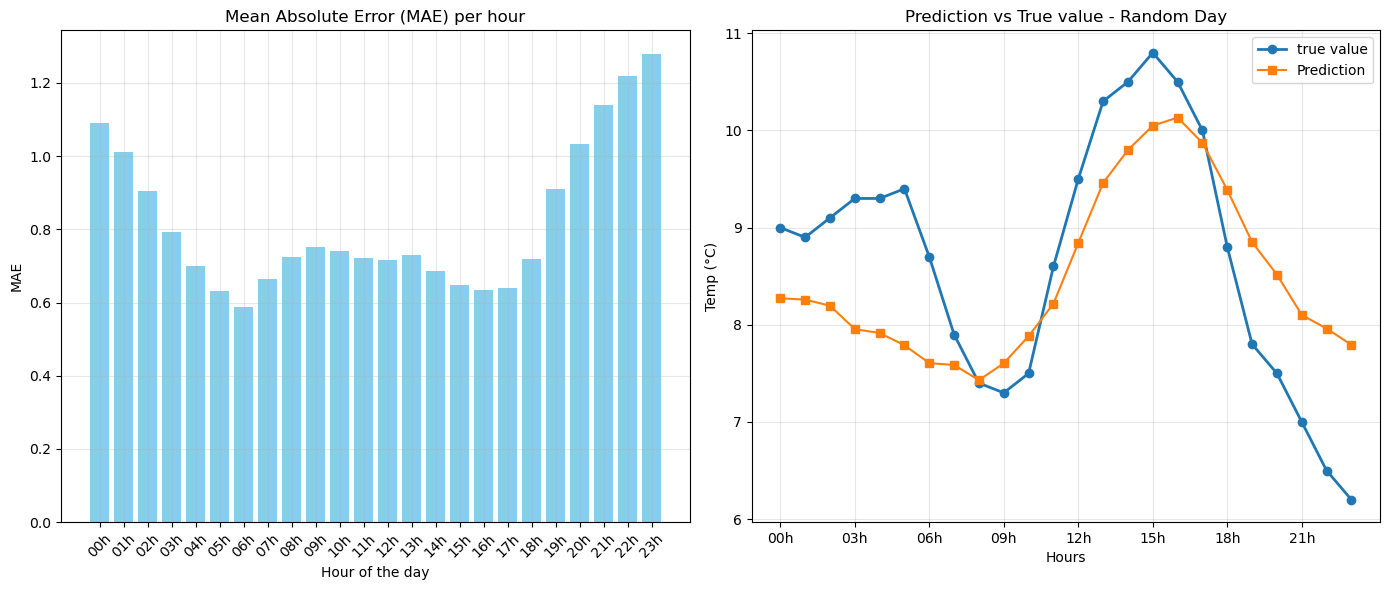


Model performance:
Mean MAE: 0.8198°C
Max MAE (at 23h): 1.2798°C
Min MAE (at 06h): 0.5876°C


In [48]:
model_temp, hourly_mae_temp = train_and_evaluate_model_temporal_split(X_temp, y_temp, y_scaler_temp, train_model=train_model, evaluate_model=evaluate_model, pred="temp")


Séparation des données:
Train: 5420 échantillons
Test: 1356 échantillons

Début de l'entraînement du modèle...

Entraînement fold 1/5
Taille train: 905, validation: 903


/home/david/anaconda/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_range (TanhRange)          │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,808 (182.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1223.4797 - mae: 20.8846 - val_loss: 55.6396 - val_mae: 3.8307 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8223 - mae: 0.8590 - val_loss: 1.1692 - val_mae: 0.5560 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2272 - mae: 0.6572 - val_loss: 1.0788 - val_mae: 0.5725 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2151 - mae: 0.6608 - val_loss: 1.1040 - val_mae: 0.6043 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1824 - mae: 0.6574 - val_loss: 1.1174 - val_mae: 0.6186 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1867 - mae: 0.6599 - val_loss: 1.1246 - val_mae: 0.6264 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1781 - mae: 0.6539 - val_loss: 1.1284 - val_mae: 0.6310 - learning_rate: 0.0010
Epoch 8

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_range_1 (TanhRange)        │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,808 (182.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 574.5234 - mae: 10.1875 - val_loss: 1.0584 - val_mae: 0.5336 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2066 - mae: 0.6376 - val_loss: 1.1215 - val_mae: 0.6290 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1549 - mae: 0.6359 - val_loss: 1.1405 - val_mae: 0.6477 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1737 - mae: 0.6300 - val_loss: 1.1337 - val_mae: 0.6444 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1364 - mae: 0.6244 - val_loss: 1.1280 - val_mae: 0.6415 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1462 - mae: 0.6238 - val_loss: 1.1177 - val_mae: 0.6354 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1323 - mae: 0.6167 - val_loss: 1.1157 - val_mae: 0.6350 - learning_rate: 5.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_range_2 (TanhRange)        │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,808 (182.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 331.6691 - mae: 6.3940 - val_loss: 1.1311 - val_mae: 0.6110 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1956 - mae: 0.6424 - val_loss: 1.1808 - val_mae: 0.6579 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1755 - mae: 0.6387 - val_loss: 1.1815 - val_mae: 0.6619 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1701 - mae: 0.6368 - val_loss: 1.1564 - val_mae: 0.6458 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1645 - mae: 0.6276 - val_loss: 1.1377 - val_mae: 0.6348 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1631 - mae: 0.6165 - val_loss: 1.1029 - val_mae: 0.6107 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1249 - mae: 0.6032 - val_loss: 1.0753 - val_mae: 0.5909 - learning_rate: 0.0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_range_3 (TanhRange)        │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,808 (182.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 343.8606 - mae: 6.4430 - val_loss: 1.1020 - val_mae: 0.6015 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1600 - mae: 0.6359 - val_loss: 1.1255 - val_mae: 0.6326 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1313 - mae: 0.6253 - val_loss: 1.1048 - val_mae: 0.6208 - learning_rate: 0.0010
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1320 - mae: 0.6160 - val_loss: 1.0853 - val_mae: 0.6067 - learning_rate: 0.0010
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0991 - mae: 0.6008 - val_loss: 1.0438 - val_mae: 0.5780 - learning_rate: 0.0010
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0747 - mae: 0.5828 - val_loss: 1.0148 - val_mae: 0.5576 - learning_rate: 0.0010
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0435 - mae: 0.5623 - val_loss: 0.9753 - val_mae: 0.5289 - learning_rate: 0.0

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh_range_4 (TanhRange)        │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,808 (182.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 252.8055 - mae: 4.9504 - val_loss: 1.0682 - val_mae: 0.5826 - learning_rate: 0.0010
Epoch 2/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1411 - mae: 0.6287 - val_loss: 1.0604 - val_mae: 0.5824 - learning_rate: 0.0010
Epoch 3/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1122 - mae: 0.6151 - val_loss: 1.0347 - val_mae: 0.5667 - learning_rate: 0.0010
Epoch 4/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0952 - mae: 0.5999 - val_loss: 1.0051 - val_mae: 0.5459 - learning_rate: 0.0010
Epoch 5/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0552 - mae: 0.5739 - val_loss: 0.9436 - val_mae: 0.5001 - learning_rate: 0.0010
Epoch 6/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0037 - mae: 0.5376 - val_loss: 0.8752 - val_mae: 0.4400 - learning_rate: 0.0010
Epoch 7/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9657 - mae: 0.5071 - val_loss: 0.8096 - val_mae: 0.3809 - learning_rate: 0.0

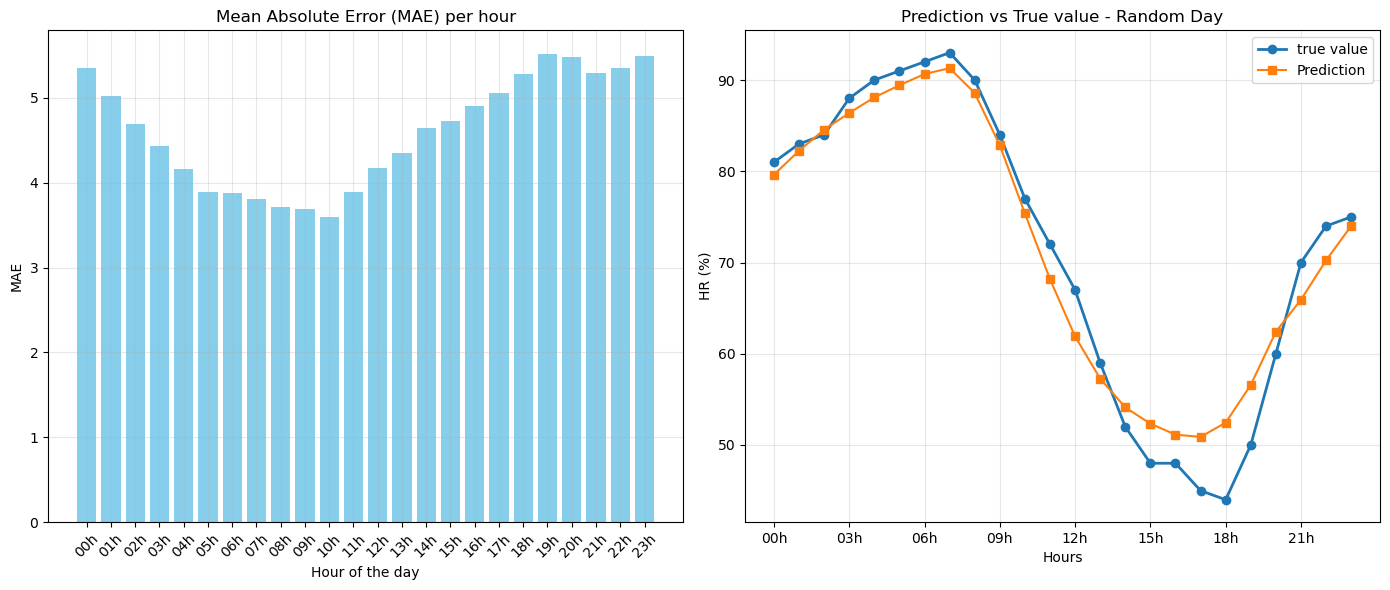


Model performance:
Mean MAE: 4.6021%
Max MAE (at 19h): 5.5207%
Min MAE (at 10h): 3.6021%


In [49]:
model_hr, hourly_mae_hr = train_and_evaluate_model_temporal_split(X_hr, y_hr, y_scaler_hr, train_model=train_model, evaluate_model=evaluate_model, pred="hr")

In [50]:
def compute_day_stats(temps_array):
    return {
        'min_temp': float(np.min(temps_array)),
        'max_temp': float(np.max(temps_array)),
        'mean_temp': float(np.mean(temps_array)),
        'day_of_year' : temps_array.index.dayofyear[0],
        'month' : temps_array.index.month[0]
    }


Exemple de prédiction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


/home/david/anaconda/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


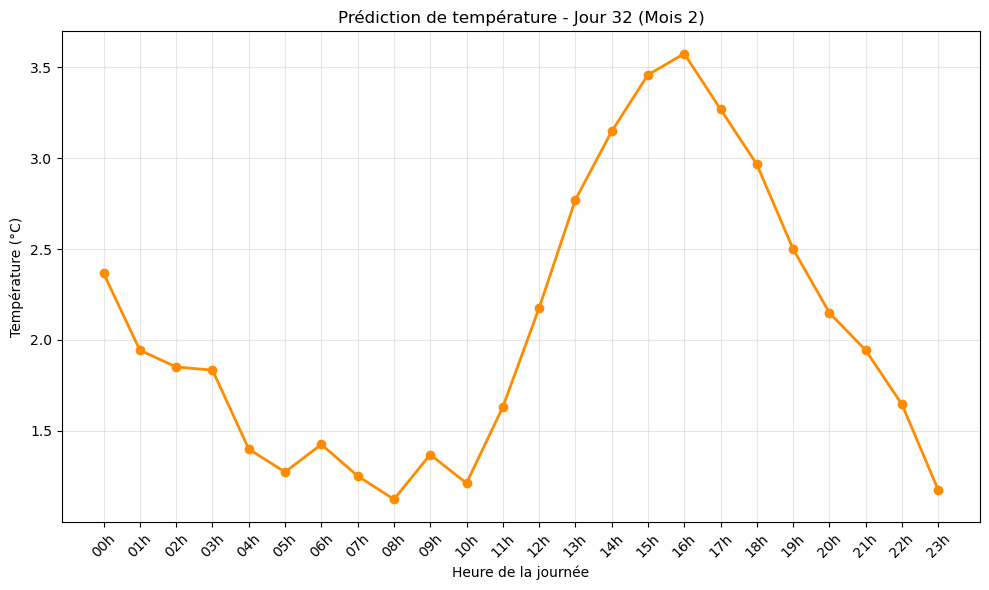

In [51]:
# Fonction de prédiction
def predict_hourly_temperatures(min_temp, max_temp, mean_temp, day_of_year, month, model, X_scaler, y_scaler):
    # Préparation de l'input
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    input_data = np.array([[min_temp, max_temp, mean_temp, 
                            day_sin, day_cos, month_sin, month_cos]])
    
    # Transformation
    scaled_input = X_scaler.transform(input_data)
    prediction = model.predict(scaled_input)
    return y_scaler.inverse_transform(prediction)[0]

# Exemple de prédiction
print("\nExemple de prédiction...")

new_day = {
    'min_temp': 0.1,
    'max_temp': 3.0,
    'mean_temp': 1.5125,
    'day_of_year': 32,
    'month': 2
}

predictions = predict_hourly_temperatures(new_day["min_temp"], new_day["max_temp"], new_day["mean_temp"], new_day["day_of_year"], new_day["month"], model_temp, X_scaler_temp, y_scaler_temp)
    
# Visualisation de la prédiction
plt.figure(figsize=(10, 6))
plt.plot(predictions, 'o-', color='darkorange', linewidth=2)
#plt.plot(data_prunay.loc["2015-02-01"]["prunay_Temperature"].values, 'o-', color='red', linewidth=2)
plt.title(f"Prédiction de température - Jour {new_day['day_of_year']} (Mois {new_day['month']})")
plt.xlabel('Heure de la journée')
plt.ylabel('Température (°C)')
plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_example.png', dpi=300)
plt.show()

In [52]:
compute_day_stats(data_prunay.loc["2015-02-01"]["prunay_Temperature"])
data_prunay.loc["2015-02-01"]["prunay_Temperature"].index.dayofyear[0]

np.int32(32)

<Axes: xlabel='time'>

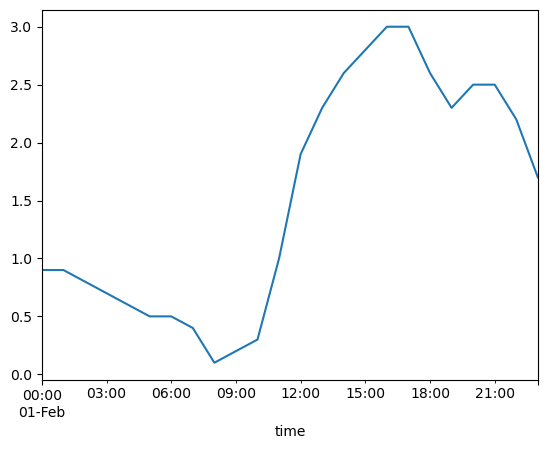

In [53]:
data_prunay.loc["2015-02-01"]["prunay_Temperature"].plot()

In [54]:
compute_day_stats(data_prunay.loc["2015-02-01"]["prunay_RH"])

{'min_temp': 79.0,
 'max_temp': 96.0,
 'mean_temp': 88.20833333333333,
 'day_of_year': np.int32(32),
 'month': np.int32(2)}

In [55]:
compute_day_stats(data_prunay.loc["2015-02-01"]["prunay_Precipitation"])

{'min_temp': 0.0,
 'max_temp': 0.5,
 'mean_temp': 0.14166666666666666,
 'day_of_year': np.int32(32),
 'month': np.int32(2)}

In [56]:
predict_hourly_temperatures(new_day["min_temp"], new_day["max_temp"], new_day["mean_temp"], new_day["day_of_year"], new_day["month"], model_temp, X_scaler_temp, y_scaler_temp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/home/david/anaconda/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([2.37, 1.94, 1.85, 1.83, 1.4 , 1.27, 1.43, 1.25, 1.12, 1.37, 1.21,
       1.63, 2.18, 2.77, 3.15, 3.46, 3.57, 3.27, 2.97, 2.5 , 2.15, 1.94,
       1.65, 1.17], dtype=float32)

In [57]:
predictions

array([2.37, 1.94, 1.85, 1.83, 1.4 , 1.27, 1.43, 1.25, 1.12, 1.37, 1.21,
       1.63, 2.18, 2.77, 3.15, 3.46, 3.57, 3.27, 2.97, 2.5 , 2.15, 1.94,
       1.65, 1.17], dtype=float32)

/home/david/anaconda/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Exemple de prédiction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


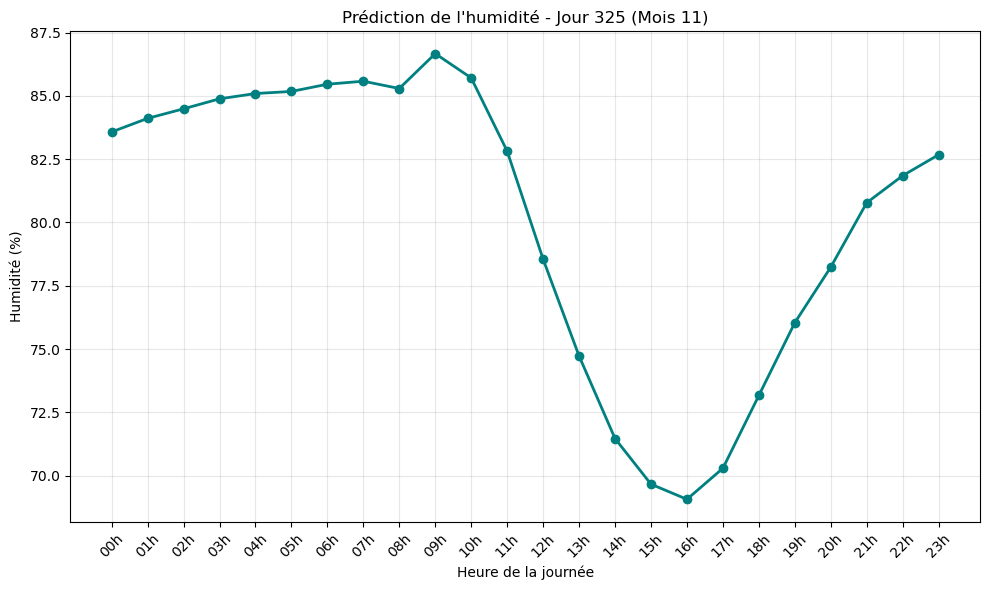

In [58]:
def predict_hourly_hr(prunay_RH_mean, prunay_Temperature_min, prunay_Temperature_max, prunay_Temperature_mean, prunay_Precipitation_mean, day_of_year, month, model, X_scaler, y_scaler):
    # Préparation de l'input
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    input_data = np.array([[prunay_RH_mean, prunay_Temperature_min, prunay_Temperature_max, prunay_Temperature_mean, prunay_Precipitation_mean,
                            day_sin, day_cos, month_sin, month_cos]])

    # Transformation
    scaled_input = X_scaler.transform(input_data)
    prediction = model.predict(scaled_input)
    return y_scaler.inverse_transform(prediction)[0]


# Exemple de prédiction
print("\nExemple de prédiction...")


new_day = {
    'prunay_RH_mean': 81.29166666666667,       # humidité moyenne journalière (%)
    'prunay_Temperature_min': 1.0,
    'prunay_Temperature_max': 5.9,
    'prunay_Temperature_mean': 3.591,
    'prunay_Precipitation_mean' : 0.0625,
    'day_of_year': 325,
    'month': 11,
}

predictions = predict_hourly_hr(new_day["prunay_RH_mean"], new_day["prunay_Temperature_min"], new_day["prunay_Temperature_max"], new_day["prunay_Temperature_mean"], new_day["prunay_Precipitation_mean"], new_day["day_of_year"], new_day["month"], model_hr, X_scaler_hr, y_scaler_hr)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(predictions, 'o-', color='teal', linewidth=2)
plt.title(f"Prédiction de l'humidité - Jour {new_day['day_of_year']} (Mois {new_day['month']})")
plt.xlabel('Heure de la journée')
plt.ylabel("Humidité (%)")
plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_humidity_example.png', dpi=300)
plt.show()

In [59]:
data_prunay.loc["2007-02-01"].resample('D').agg(['min', 'mean', 'max'])

prunay_Temperature           prunay_RH            \
                          min mean  max       min mean  max   
time                                                          
2007-02-01                4.4  7.4 10.1      86.0 90.7 97.0   

           prunay_Precipitation           
                            min mean max  
time                                      
2007-02-01                  0.0  0.0 0.0

<Axes: xlabel='time'>

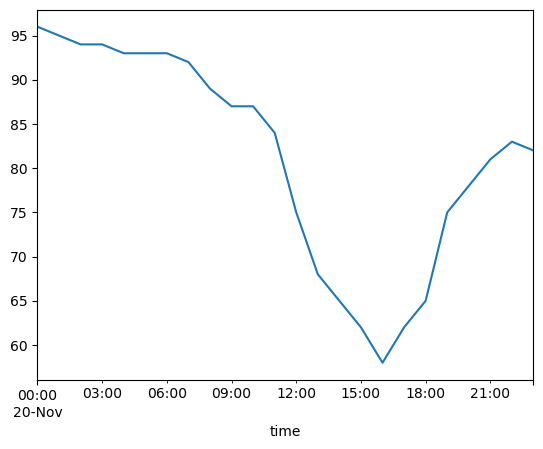

In [60]:
data_prunay.loc["2024-11-20"]["prunay_RH"].plot()

In [61]:
compute_day_stats(data_prunay.loc["2024-11-20"]["prunay_RH"])

{'min_temp': 58.0,
 'max_temp': 96.0,
 'mean_temp': 81.29166666666667,
 'day_of_year': np.int32(325),
 'month': np.int32(11)}

In [62]:
compute_day_stats(data_prunay.loc["2024-11-20"]["prunay_Temperature"])

{'min_temp': 1.0,
 'max_temp': 5.9,
 'mean_temp': 3.5916666666666663,
 'day_of_year': np.int32(325),
 'month': np.int32(11)}

In [63]:
compute_day_stats(data_prunay.loc["2024-11-20"]["prunay_Precipitation"])

{'min_temp': 0.0,
 'max_temp': 0.6,
 'mean_temp': 0.0625,
 'day_of_year': np.int32(325),
 'month': np.int32(11)}

In [64]:
data_prunay.loc["2008-07-01"]["prunay_RH"].min()

51.0

In [65]:
predictions.min()

np.float32(69.068054)

In [66]:
data_prunay.loc["2008-07-01"]["prunay_RH"].max()

92.0

In [67]:
predictions.max()

np.float32(86.66757)

In [68]:
data_prunay.loc["2007-02-01"]["prunay_RH"].mean()

np.float64(90.66666666666667)

In [69]:
predictions.mean()

np.float32(80.22335)

In [70]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_Temperature"])

{'min_temp': 15.9,
 'max_temp': 22.1,
 'mean_temp': 18.870833333333334,
 'day_of_year': np.int32(182),
 'month': np.int32(7)}

In [71]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_RH"])

{'min_temp': 66.0,
 'max_temp': 88.0,
 'mean_temp': 77.08333333333333,
 'day_of_year': np.int32(182),
 'month': np.int32(7)}

In [72]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_Precipitation"])

{'min_temp': 0.0,
 'max_temp': 0.9,
 'mean_temp': 0.0375,
 'day_of_year': np.int32(182),
 'month': np.int32(7)}

In [73]:
def predict_from_dataframe_temp(df_input, model, X_scaler, y_scaler):

    # Copie pour éviter d'altérer le DataFrame d'origine
    df = df_input.copy()

    # Ajout des features cycliques
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Features
    features = ['min', 'max', 'mean', 
                'day_sin', 'day_cos', 'month_sin', 'month_cos']

    # Normalisation
    X = X_scaler.transform(df[features])

    # Prédiction
    y_pred_scaled = model.predict(X)

    # Retour à l'échelle originale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Ajout dans le DataFrame sous forme de listes
    df['y_pred'] = [list(row) for row in y_pred]

    return df

In [74]:
def predict_from_dataframe_hr(df_input, model, X_scaler, y_scaler):

    # Copie pour éviter d'altérer le DataFrame d'origine
    df = df_input.copy()

    # Ajout des features cycliques
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Features
    features = ['prunay_RH_mean', 'prunay_Temperature_min', 'prunay_Temperature_max', 'prunay_Temperature_mean', 'prunay_Precipitation_mean',
                'day_sin', 'day_cos', 'month_sin', 'month_cos']

    # Normalisation
    X = X_scaler.transform(df[features])

    # Prédiction
    y_pred_scaled = model.predict(X)

    # Retour à l'échelle originale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Ajout dans le DataFrame sous forme de listes
    df['y_pred'] = [list(row) for row in y_pred]

    return df

In [75]:
data_rcp_2_6predict_hourly_temp = data_rcp_2_6[['tasminAdjust', 'tasmaxAdjust', 'tasAdjust']].copy()

In [76]:
data_rcp_2_6predict_hourly_hr = data_rcp_2_6[['rcp_RH', 'tasminAdjust', 'tasmaxAdjust', 'tasAdjust', 'prtotAdjust']].copy()

In [77]:
data_rcp_2_6predict_hourly_temp

,tasminAdjust,tasmaxAdjust,tasAdjust
Date,,,
2006-01-01,-3.1,4.6,-0.0
2006-01-02,0.2,4.0,2.1
2006-01-03,8.6,9.2,9.0
2006-01-04,9.9,14.2,12.7
2006-01-05,7.6,11.5,9.0
...,...,...,...
2100-12-27,0.7,4.6,2.6
2100-12-28,-0.7,2.5,0.7
2100-12-29,-1.1,1.2,-0.2


In [78]:
data_rcp_2_6predict_hourly_hr

,rcp_RH,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust
Date,,,,,
2006-01-01,93.6,-3.1,4.6,-0.0,0.0
2006-01-02,100.0,0.2,4.0,2.1,8.8
2006-01-03,100.0,8.6,9.2,9.0,0.7
2006-01-04,90.0,9.9,14.2,12.7,0.5
2006-01-05,95.8,7.6,11.5,9.0,0.0
...,...,...,...,...,...
2100-12-27,77.2,0.7,4.6,2.6,0.0
2100-12-28,85.5,-0.7,2.5,0.7,1.0
2100-12-29,95.3,-1.1,1.2,-0.2,0.4


In [79]:
data_rcp_2_6predict_hourly_temp.rename(columns={"tasminAdjust": "min", "tasmaxAdjust": "max", "tasAdjust": "mean"}, inplace=True)

In [80]:
data_rcp_2_6predict_hourly_hr.rename(columns={"rcp_RH": "prunay_RH_mean", "tasminAdjust": "prunay_Temperature_min", "tasmaxAdjust": "prunay_Temperature_max", "tasAdjust": "prunay_Temperature_mean", "prtotAdjust": "prunay_Precipitation_mean"}, inplace=True)

In [81]:
data_rcp_2_6predict_hourly_temp["day_of_year"] = data_rcp_2_6predict_hourly_temp.index.dayofyear
data_rcp_2_6predict_hourly_temp["month"] = data_rcp_2_6predict_hourly_temp.index.month

In [82]:
data_rcp_2_6predict_hourly_hr["day_of_year"] = data_rcp_2_6predict_hourly_hr.index.dayofyear
data_rcp_2_6predict_hourly_hr["month"] = data_rcp_2_6predict_hourly_hr.index.month

In [83]:
data_rcp_2_6predict_hourly_temp = predict_from_dataframe_temp(data_rcp_2_6predict_hourly_temp, model=model_temp, X_scaler=X_scaler_temp, y_scaler=y_scaler_temp)

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [84]:
data_rcp_2_6predict_hourly_hr = predict_from_dataframe_hr(data_rcp_2_6predict_hourly_hr, model=model_hr, X_scaler=X_scaler_hr, y_scaler=y_scaler_hr)

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step


In [85]:
data_rcp_2_6predict_hourly_hr

,prunay_RH_mean,prunay_Temperature_min,prunay_Temperature_max,prunay_Temperature_mean,prunay_Precipitation_mean,day_of_year,month,day_sin,day_cos,month_sin,month_cos,y_pred
Date,,,,,,,,,,,,
2006-01-01,93.6,-3.1,4.6,-0.0,0.0,1,1,0.0,1.0,0.5,0.9,"[94.149796, 94.66039, 95.16307, 95.49995, 95.6..."
2006-01-02,100.0,0.2,4.0,2.1,8.8,2,1,0.0,1.0,0.5,0.9,"[41.524246, 41.575245, 42.26025, 43.832035, 39..."
2006-01-03,100.0,8.6,9.2,9.0,0.7,3,1,0.1,1.0,0.5,0.9,"[93.36365, 93.57217, 94.2158, 94.859886, 95.45..."
2006-01-04,90.0,9.9,14.2,12.7,0.5,4,1,0.1,1.0,0.5,0.9,"[88.6149, 88.972084, 89.48024, 90.11451, 90.51..."
2006-01-05,95.8,7.6,11.5,9.0,0.0,5,1,0.1,1.0,0.5,0.9,"[95.06776, 95.53064, 96.08786, 96.52101, 96.86..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,77.2,0.7,4.6,2.6,0.0,361,12,-0.1,1.0,-0.0,1.0,"[81.0915, 81.17601, 81.11911, 81.26141, 81.299..."
2100-12-28,85.5,-0.7,2.5,0.7,1.0,362,12,-0.1,1.0,-0.0,1.0,"[84.533844, 84.71686, 85.08485, 85.72224, 86.0..."
2100-12-29,95.3,-1.1,1.2,-0.2,0.4,363,12,-0.0,1.0,-0.0,1.0,"[91.50778, 91.89171, 92.422, 92.98387, 93.4791..."


In [86]:
data_rcp_2_6predict_hourly_temp

,min,max,mean,day_of_year,month,day_sin,day_cos,month_sin,month_cos,y_pred
Date,,,,,,,,,,
2006-01-01,-3.1,4.6,-0.0,1,1,0.0,1.0,0.5,0.9,"[-0.90256476, -1.2546037, -1.4451953, -1.72906..."
2006-01-02,0.2,4.0,2.1,2,1,0.0,1.0,0.5,0.9,"[2.6598003, 2.4982383, 2.3720393, 2.1917212, 2..."
2006-01-03,8.6,9.2,9.0,3,1,0.1,1.0,0.5,0.9,"[9.228014, 9.297093, 9.334881, 9.157602, 9.241..."
2006-01-04,9.9,14.2,12.7,4,1,0.1,1.0,0.5,0.9,"[12.061816, 12.009413, 11.917204, 11.92537, 11..."
2006-01-05,7.6,11.5,9.0,5,1,0.1,1.0,0.5,0.9,"[8.903207, 8.963866, 8.83055, 8.566603, 8.5940..."
...,...,...,...,...,...,...,...,...,...,...
2100-12-27,0.7,4.6,2.6,361,12,-0.1,1.0,-0.0,1.0,"[2.9194353, 2.8215382, 2.6635284, 2.442437, 2...."
2100-12-28,-0.7,2.5,0.7,362,12,-0.1,1.0,-0.0,1.0,"[1.149338, 0.9328066, 0.84675497, 0.653992, 0...."
2100-12-29,-1.1,1.2,-0.2,363,12,-0.0,1.0,-0.0,1.0,"[0.23537181, 0.06715932, 0.02211563, -0.185772..."


In [87]:
df_hourly_temp = data_rcp_2_6predict_hourly_temp[["y_pred"]].copy()

In [88]:
df_hourly_hr = data_rcp_2_6predict_hourly_hr[["y_pred"]].copy()

In [89]:
def daily_to_hourly(df, value_col="y"):
    """
    Transforme un DataFrame journalier (1 ligne = 1 jour, 1 cellule = 24 valeurs)
    en DataFrame horaire (1 ligne = 1 heure).
    
    Paramètres :
    ------------
    df : pd.DataFrame
        DataFrame journalier, index = dates, colonne = listes de 24 valeurs horaires.
    value_col : str
        Nom de la colonne contenant les valeurs horaires.

    Retour :
    --------
    df_hourly : pd.DataFrame
        DataFrame horaire, index = datetime (jour + heure), colonnes : ['y']
    """
    df = df.copy()

    # Assurer que l’index est de type datetime
    df.index = pd.to_datetime(df.index)

    # Répéter chaque ligne 24 fois
    df_expanded = df.loc[df.index.repeat(24)].copy()

    # Aplatir les valeurs horaires
    df_expanded[value_col] = df[value_col].explode().values

    # Ajouter les heures (0 à 23)
    df_expanded["hour"] = list(range(24)) * len(df)

    # Créer l’index horaire
    df_expanded["datetime"] = df_expanded.index + pd.to_timedelta(df_expanded["hour"], unit='h')

    # Finaliser
    df_hourly = df_expanded[["datetime", value_col]].set_index("datetime").sort_index()

    return df_hourly


In [90]:
df_hourly_temp = daily_to_hourly(df_hourly_temp, "y_pred")

In [91]:
df_hourly_hr = daily_to_hourly(df_hourly_hr, "y_pred")

In [92]:
df_hourly_temp

,y_pred
datetime,
2006-01-01 00:00:00,-0.9
2006-01-01 01:00:00,-1.3
2006-01-01 02:00:00,-1.4
2006-01-01 03:00:00,-1.7
2006-01-01 04:00:00,-1.9
...,...
2100-12-31 19:00:00,1.3
2100-12-31 20:00:00,1.1
2100-12-31 21:00:00,0.8


In [93]:
df_hourly_hr

,y_pred
datetime,
2006-01-01 00:00:00,94.1
2006-01-01 01:00:00,94.7
2006-01-01 02:00:00,95.2
2006-01-01 03:00:00,95.5
2006-01-01 04:00:00,95.6
...,...
2100-12-31 19:00:00,83.6
2100-12-31 20:00:00,84.9
2100-12-31 21:00:00,86.1


In [94]:
df_hourly_temp.max()

y_pred   52.7
dtype: object

In [95]:
df_hourly_temp.min()

y_pred   -19.6
dtype: object

In [96]:
(df_hourly_temp < -10).sum()

y_pred    814
dtype: int64

In [97]:
df_hourly_hr.max()

y_pred   103.6
dtype: object

In [98]:
df_hourly_hr.min()

y_pred   15.0
dtype: object

In [99]:
(df_hourly_hr < 0).sum()

y_pred    0
dtype: int64

In [100]:
(df_hourly_hr > 100).sum()

y_pred    3991
dtype: int64

In [101]:
def pourcentages_par_intervalles(array):
    array = np.array(array)
    total = len(array)

    pct_0_30     = np.sum((array >= 0) & (array < 30)) / total * 100
    pct_30_50    = np.sum((array >= 30) & (array < 50)) / total * 100
    pct_50_70    = np.sum((array >= 50) & (array < 70)) / total * 100
    pct_70_90    = np.sum((array >= 70) & (array < 90)) / total * 100
    pct_90_100   = np.sum((array >= 90) & (array < 100)) / total * 100
    pct_eq_100   = np.sum(array == 100) / total * 100
    pct_sup_100  = np.sum(array > 100) / total * 100

    return {
        '0–30%': pct_0_30,
        '30–50%': pct_30_50,
        '50–70%': pct_50_70,
        '70–90%': pct_70_90,
        '90–100%': pct_90_100,
        '==100%': pct_eq_100,
        '>100%': pct_sup_100
    }

/tmp/ipykernel_1499914/1397230908.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'rcp_RH'),
  Text(1, 0, 'prtotAdjust'),
  Text(2, 0, 'prsnAdjust'),
  Text(3, 0, 'sfcWindAdjust'),
  Text(4, 0, 'rldsAdjust'),
  Text(5, 0, 'hussAdjust'),
  Text(6, 0, 'tasminAdjust'),
  Text(7, 0, 'tasAdjust'),
  Text(8, 0, 'tasmaxAdjust'),
  Text(9, 0, 'rsdsAdjust'),
  Text(10, 0, 'evspsblpotAdjust'),
  Text(11, 0, 'Latitude'),
  Text(12, 0, 'Longitude')])

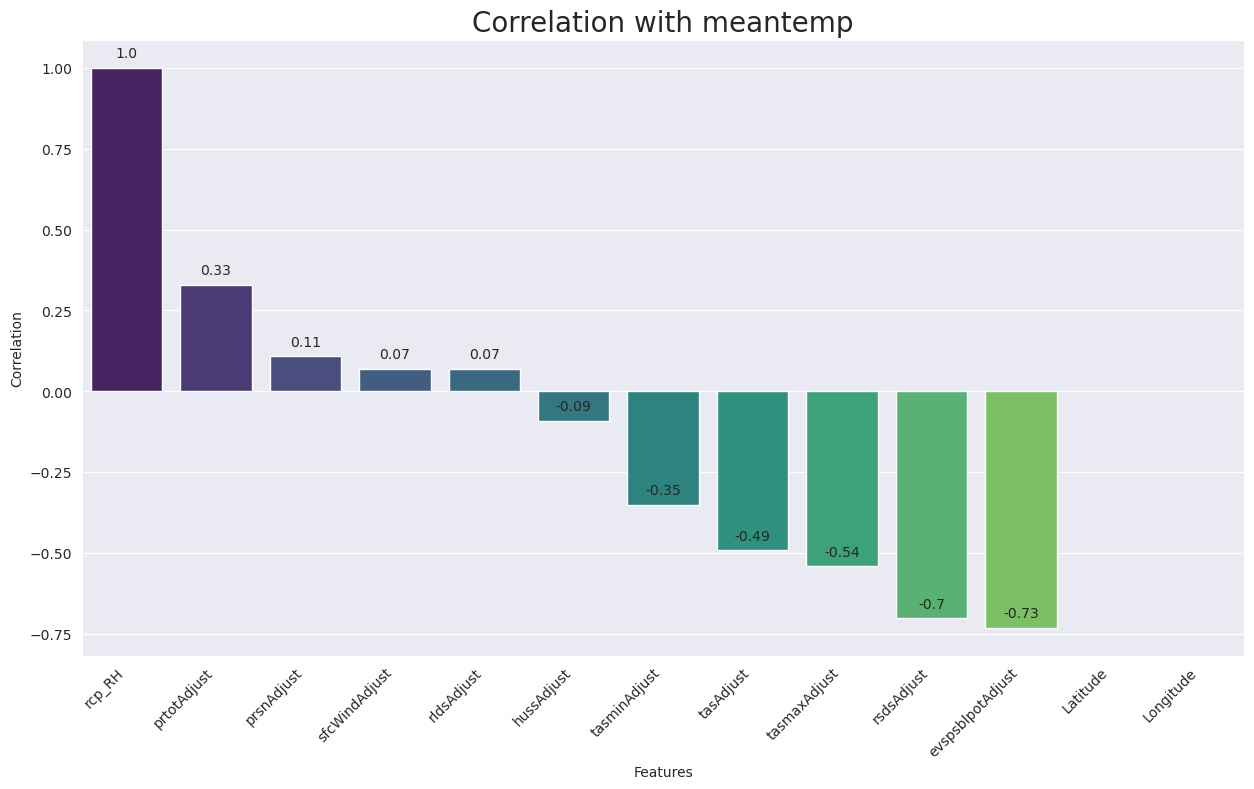

In [102]:
plt.figure(figsize=(15, 8))
sns.set_style('darkgrid')

correlation_matrix = round(data_rcp_2_6.select_dtypes('number').corr(), 2)

correlation_with_trgt = correlation_matrix['rcp_RH'].sort_values(ascending=False)

ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')

plt.title('Correlation with meantemp', size= 20)
plt.xlabel('Features')
plt.ylabel('Correlation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')

In [103]:
pourcentages_par_intervalles(df_hourly_hr)

{'0–30%': np.float64(3.342892001460219),
 '30–50%': np.float64(12.732001844486716),
 '50–70%': np.float64(21.568005840874594),
 '70–90%': np.float64(40.30839913923953),
 '90–100%': np.float64(21.569446846119853),
 '==100%': np.float64(0.0),
 '>100%': np.float64(0.4792543278190866)}

In [104]:
pourcentages_par_intervalles(data_prunay["prunay_RH"])

{'0–30%': np.float64(0.28900490078523244),
 '30–50%': np.float64(6.370405898159593),
 '50–70%': np.float64(22.28596727480677),
 '70–90%': np.float64(43.850037201694676),
 '90–100%': np.float64(26.763083620800977),
 '==100%': np.float64(0.44150110375275936),
 '>100%': np.float64(0.0)}

In [105]:
(df_hourly_hr > 100).sum()

y_pred    3991
dtype: int64

In [106]:
df_hourly_hr[df_hourly_hr >= 100] = 100

In [107]:
df_hourly_hr

,y_pred
datetime,
2006-01-01 00:00:00,94.1
2006-01-01 01:00:00,94.7
2006-01-01 02:00:00,95.2
2006-01-01 03:00:00,95.5
2006-01-01 04:00:00,95.6
...,...
2100-12-31 19:00:00,83.6
2100-12-31 20:00:00,84.9
2100-12-31 21:00:00,86.1


In [108]:
df_hourly_temp

,y_pred
datetime,
2006-01-01 00:00:00,-0.9
2006-01-01 01:00:00,-1.3
2006-01-01 02:00:00,-1.4
2006-01-01 03:00:00,-1.7
2006-01-01 04:00:00,-1.9
...,...
2100-12-31 19:00:00,1.3
2100-12-31 20:00:00,1.1
2100-12-31 21:00:00,0.8


In [109]:
df_hourly_temp.rename(columns={"y_pred": "rcp_2_6_Temperature"}, inplace=True)
df_hourly_hr.rename(columns={"y_pred": "rcp_2_6_RH"}, inplace=True)

In [110]:
data_rcp_2_6_hourly_temp_hr = pd.concat([df_hourly_temp, df_hourly_hr], axis=1)

In [111]:
data_rcp_2_6_hourly_temp_hr.loc["2024-07"]

,rcp_2_6_Temperature,rcp_2_6_RH
datetime,,
2024-07-01 00:00:00,15.1,85.5
2024-07-01 01:00:00,14.6,87.3
2024-07-01 02:00:00,14.0,88.6
2024-07-01 03:00:00,13.5,89.6
2024-07-01 04:00:00,13.1,90.2
...,...,...
2024-07-31 19:00:00,19.7,64.8
2024-07-31 20:00:00,19.2,68.1
2024-07-31 21:00:00,18.2,72.7


In [112]:
data_prunay[data_prunay["prunay_Temperature"] < 1] 

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-15 04:00:00,0.9,96.0,0.0
2007-01-15 05:00:00,0.7,96.0,0.0
2007-01-15 06:00:00,0.5,95.0,0.0
2007-01-15 07:00:00,0.0,96.0,0.0
2007-01-15 08:00:00,-0.0,96.0,0.0
...,...,...,...
2025-03-17 09:00:00,0.5,80.0,0.0
2025-03-18 06:00:00,0.9,62.0,0.0
2025-03-18 07:00:00,0.4,62.0,0.0


In [113]:
data_prunay.loc["2024-07", ["prunay_Temperature", "prunay_RH"]]

,prunay_Temperature,prunay_RH
time,,
2024-07-01 00:00:00,17.1,83.0
2024-07-01 01:00:00,16.3,92.0
2024-07-01 02:00:00,15.9,95.0
2024-07-01 03:00:00,15.6,93.0
2024-07-01 04:00:00,14.8,96.0
...,...,...
2024-07-31 19:00:00,28.5,63.0
2024-07-31 20:00:00,27.4,71.0
2024-07-31 21:00:00,25.3,82.0


In [114]:
data_rcp_2_6_hourly_temp_hr

,rcp_2_6_Temperature,rcp_2_6_RH
datetime,,
2006-01-01 00:00:00,-0.9,94.1
2006-01-01 01:00:00,-1.3,94.7
2006-01-01 02:00:00,-1.4,95.2
2006-01-01 03:00:00,-1.7,95.5
2006-01-01 04:00:00,-1.9,95.6
...,...,...
2100-12-31 19:00:00,1.3,83.6
2100-12-31 20:00:00,1.1,84.9
2100-12-31 21:00:00,0.8,86.1


In [115]:
data_rcp_2_6_hourly_temp_hr

,rcp_2_6_Temperature,rcp_2_6_RH
datetime,,
2006-01-01 00:00:00,-0.9,94.1
2006-01-01 01:00:00,-1.3,94.7
2006-01-01 02:00:00,-1.4,95.2
2006-01-01 03:00:00,-1.7,95.5
2006-01-01 04:00:00,-1.9,95.6
...,...,...
2100-12-31 19:00:00,1.3,83.6
2100-12-31 20:00:00,1.1,84.9
2100-12-31 21:00:00,0.8,86.1


In [116]:
data_rcp_2_6_hourly_temp_hr.loc["2007"]

,rcp_2_6_Temperature,rcp_2_6_RH
datetime,,
2007-01-01 00:00:00,4.7,95.8
2007-01-01 01:00:00,4.7,96.3
2007-01-01 02:00:00,4.6,96.8
2007-01-01 03:00:00,4.4,97.3
2007-01-01 04:00:00,4.5,97.6
...,...,...
2007-12-31 19:00:00,-1.1,77.4
2007-12-31 20:00:00,-1.8,78.7
2007-12-31 21:00:00,-2.2,80.5


In [117]:
data_prunay 

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


#### **LSTM**

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.


In [118]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6_hourly_temp_hr.index.intersection(data_prunay.index)
data_rcp_2_6_hourly_temp_hr_ = data_rcp_2_6_hourly_temp_hr.loc[common_index_data_rcp_2_6]

In [119]:
data_rcp_2_6_hourly_temp_hr_["prunay_Temperature"] = data_prunay["prunay_Temperature"]

In [120]:
data_rcp_2_6_hourly_temp_hr_["prunay_RH"] = data_prunay["prunay_RH"]

In [123]:
data_rcp_2_6_hourly_temp_hr_predict_temp = data_rcp_2_6_hourly_temp_hr_[['rcp_2_6_Temperature', 'rcp_2_6_RH', 'prunay_Temperature']].copy()

In [ ]:
data_rcp_2_6_hourly_temp_hr_predict_hr = data_rcp_2_6_hourly_temp_hr_[['rcp_2_6_Temperature', 'rcp_2_6_RH', 'prunay_RH']].copy()

In [134]:
data_rcp_2_6_hourly_temp_hr_predict_hr

,rcp_2_6_Temperature,rcp_2_6_RH,prunay_RH
2007-01-01 00:00:00,4.7,95.8,91.0
2007-01-01 01:00:00,4.7,96.3,93.0
2007-01-01 02:00:00,4.6,96.8,91.0
2007-01-01 03:00:00,4.4,97.3,90.0
2007-01-01 04:00:00,4.5,97.6,90.0
...,...,...,...
2025-07-20 22:00:00,37.4,30.7,69.0
2025-07-20 23:00:00,35.0,32.8,74.0
2025-07-21 00:00:00,20.3,62.7,75.0
2025-07-21 01:00:00,19.7,65.3,75.0


In [125]:
# Paramètres du modèle
WINDOW_SIZE = 24  # Fenêtre de 24 heures (ajustable)
PREDICTION_HORIZON = 1  # Prédire l'heure suivante
TEST_SIZE = 0.2  # 20% pour le test

# Features et target
FEATURES = ['rcp_2_6_Temperature', 'rcp_2_6_RH']
TARGET = 'prunay_Temperature'

In [ ]:
# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scaling des features
X_scaled = scaler_X.fit_transform(data_rcp_2_6_hourly_temp_hr_predict_temp[FEATURES])
# Scaling de la target
y_scaled = scaler_y.fit_transform(data_rcp_2_6_hourly_temp_hr_predict_temp[[TARGET]])

# Création des séquences pour LSTM
def create_sequences(X, y, window_size, prediction_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - prediction_horizon + 1):
        X_seq.append(X[i:(i + window_size)])
        y_seq.append(y[i + window_size + prediction_horizon - 1])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, WINDOW_SIZE, PREDICTION_HORIZON)

print(f"Forme des séquences X: {X_sequences.shape}")
print(f"Forme des séquences y: {y_sequences.shape}")

Forme des séquences X: (162603, 24, 2)
Forme des séquences y: (162603, 1)


In [127]:
# Division train/test
split_idx = int(len(X_sequences) * (1 - TEST_SIZE))

X_train = X_sequences[:split_idx]
X_test = X_sequences[split_idx:]
y_train = y_sequences[:split_idx]
y_test = y_sequences[split_idx:]

print(f"Train shapes: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test shapes: X_test {X_test.shape}, y_test {y_test.shape}")

Train shapes: X_train (130082, 24, 2), y_train (130082, 1)
Test shapes: X_test (32521, 24, 2), y_test (32521, 1)


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        
        LSTM(25, return_sequences=False),
        Dropout(0.2),
        
        Dense(25, activation='relu'),
        Dense(1)  # Sortie pour la prédiction de température
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Construction du modèle
input_shape = (X_train.shape[1], X_train.shape[2])  # (window_size, n_features)
model = build_lstm_model(input_shape)

print(model.summary())

/home/david/anaconda/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,401 (603.13 KB)

 Trainable params: 154,401 (603.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [129]:

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=10, factor=0.5)
]

# Entraînement
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.3952 - mae: 0.4957 - val_loss: 0.3920 - val_mae: 0.4884 - learning_rate: 0.0010
Epoch 2/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3695 - mae: 0.4803 - val_loss: 0.3783 - val_mae: 0.4837 - learning_rate: 0.0010
Epoch 3/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3603 - mae: 0.4751 - val_loss: 0.3647 - val_mae: 0.4729 - learning_rate: 0.0010
Epoch 4/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3473 - mae: 0.4674 - val_loss: 0.3615 - val_mae: 0.4694 - learning_rate: 0.0010
Epoch 5/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3388 - mae: 0.4624 - val_loss: 0.3449 - val_mae: 0.4580 - learning_rate: 0.0010
Epoch 6/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3315 - mae: 0.4583 - val_loss: 0.3549 - val_mae: 0.4638 - learning_rate: 0.0010
Epoch 7/100
1627/1627 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3244 - mae: 0.4535 - val_loss: 0.3529 - val_mae: 0.4628 - learni

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 3.40°C
RMSE: 4.25°C


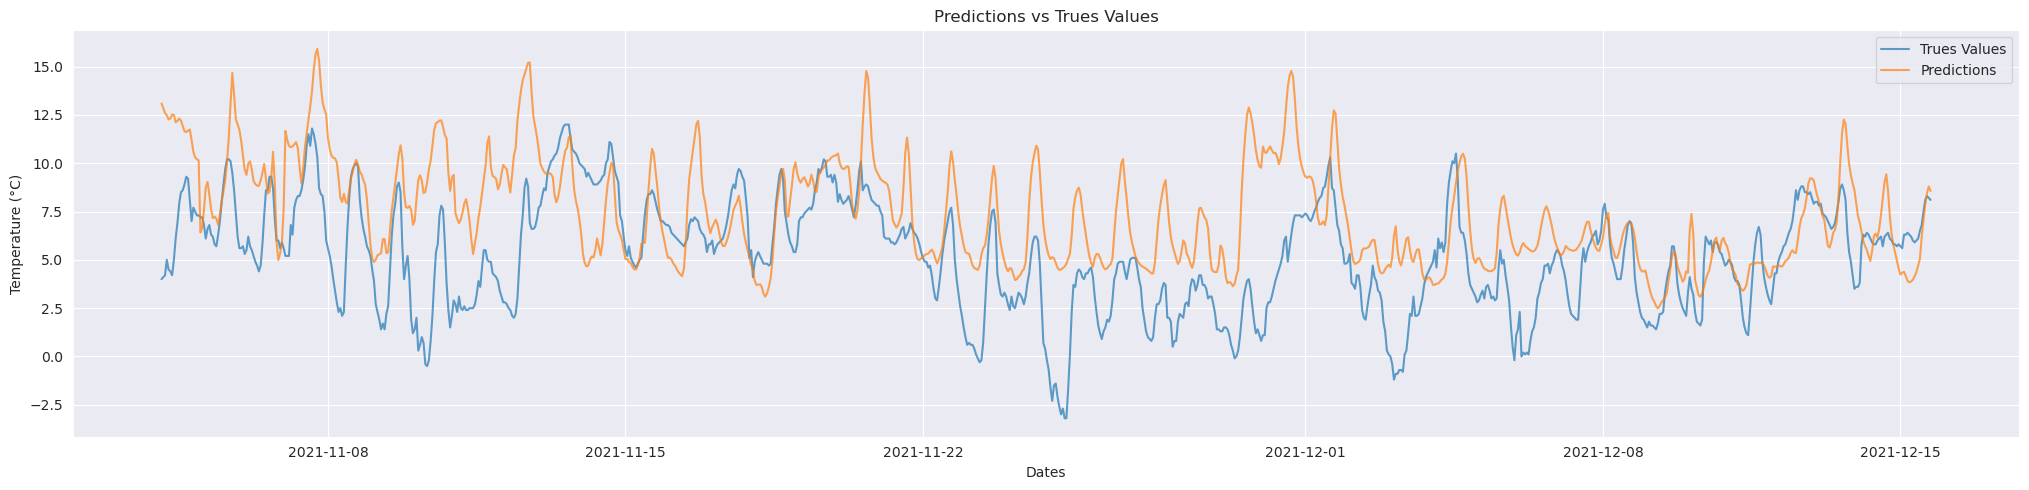

In [148]:
# Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Récupération des dates pour le test set
dates = data_rcp_2_6_hourly_temp_hr_predict_temp.index[WINDOW_SIZE + PREDICTION_HORIZON - 1:]
test_dates = dates[split_idx:split_idx + len(X_test)]

# Métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}°C")
print(f"RMSE: {rmse:.2f}°C")

# Visualisation des résultats
plt.figure(figsize=(40, 5))

# Courbes de prédiction
plt.subplot(1, 2, 1)
plt.plot(test_dates[:1000], y_true[:1000], label='Trues Values', alpha=0.7)
plt.plot(test_dates[:1000], y_pred[:1000], label='Predictions', alpha=0.7)
plt.title('Predictions vs Trues Values')
plt.xlabel('Dates')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

In [131]:
# Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}°C")
print(f"RMSE: {rmse:.2f}°C")

# Récupération des dates correspondantes pour le test set
# On suppose que vos données originales ont un index datetime
dates = # Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}°C")
print(f"RMSE: {rmse:.2f}°C")

# Récupération des dates correspondantes pour le test set
# On suppose que vos données originales ont un index datetime
dates = data_rcp_2_6_hourly_temp_hr_predict_temp.index[WINDOW_SIZE + PREDICTION_HORIZON - 1:]  # Ajuster selon la création des séquences
test_dates = dates[split_idx:split_idx + len(X_test)]

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Courbes de prédiction avec dates
plt.subplot(1, 2, 1)
plt.plot(test_dates[:500], y_true[:500], label='Vraies valeurs', alpha=0.7)
plt.plot(test_dates[:500], y_pred[:500], label='Prédictions', alpha=0.7)
plt.title('Prédictions vs Valeurs réelles')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Histogramme des erreurs
plt.subplot(1, 2, 2)
errors = y_true.flatten() - y_pred.flatten()
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Distribution des erreurs')
plt.xlabel('Erreur (°C)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Affichage des dates de la période de test
print(f"\nPériode de test : du {test_dates.iloc[0]} au {test_dates.iloc[-1]}")
print(f"Nombre d'échantillons de test : {len(test_dates)}")

# Graphique supplémentaire avec zoom sur une période spécifique
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:168], y_true[:168], label='Vraies valeurs', marker='o', markersize=2)
plt.plot(test_dates[:168], y_pred[:168], label='Prédictions', marker='x', markersize=2)
plt.title('Prédictions vs Valeurs réelles - Première semaine de test')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Affichage de quelques prédictions avec dates
print("\nExemples de prédictions :")
sample_indices = [0, 100, 200, 300, 400]
for idx in sample_indices:
    if idx < len(test_dates):
        print(f"{test_dates.iloc[idx]}: Vrai = {y_true[idx][0]:.2f}°C, Prédit = {y_pred[idx][0]:.2f}°C, Erreur = {errors[idx]:.2f}°C").index[WINDOW_SIZE + PREDICTION_HORIZON - 1:]  # Ajuster selon la création des séquences
test_dates = dates[split_idx:split_idx + len(X_test)]

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Courbes de prédiction avec dates
plt.subplot(1, 2, 1)
plt.plot(test_dates[:500], y_true[:500], label='Vraies valeurs', alpha=0.7)
plt.plot(test_dates[:500], y_pred[:500], label='Prédictions', alpha=0.7)
plt.title('Prédictions vs Valeurs réelles')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Histogramme des erreurs
plt.subplot(1, 2, 2)
errors = y_true.flatten() - y_pred.flatten()
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Distribution des erreurs')
plt.xlabel('Erreur (°C)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Affichage des dates de la période de test
print(f"\nPériode de test : du {test_dates.iloc[0]} au {test_dates.iloc[-1]}")
print(f"Nombre d'échantillons de test : {len(test_dates)}")

# Graphique supplémentaire avec zoom sur une période spécifique
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:168], y_true[:168], label='Vraies valeurs', marker='o', markersize=2)
plt.plot(test_dates[:168], y_pred[:168], label='Prédictions', marker='x', markersize=2)
plt.title('Prédictions vs Valeurs réelles - Première semaine de test')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Affichage de quelques prédictions avec dates
print("\nExemples de prédictions :")
sample_indices = [0, 100, 200, 300, 400]
for idx in sample_indices:
    if idx < len(test_dates):
        print(f"{test_dates.iloc[idx]}: Vrai = {y_true[idx][0]:.2f}°C, Prédit = {y_pred[idx][0]:.2f}°C, Erreur = {errors[idx]:.2f}°C")

SyntaxError: invalid syntax (2102299130.py, line 15)

In [ ]:
def predict_temperature(rcp_temp, rcp_rh, model, scaler_X, scaler_y, window_size):
    """
    Prédit la température de Prunay à partir des nouvelles données RCP
    """
    # Création du tableau d'input
    new_data = np.array([[rcp_temp, rcp_rh]])
    
    # Scaling
    new_data_scaled = scaler_X.transform(new_data)
    
    # Ici vous devriez avoir une fenêtre glissante complète
    # Pour une démo simple, on suppose qu'on a déjà une séquence complète
    # En pratique, vous devrez maintenir une fenêtre des dernières observations
    
    # Prédiction (exemple simplifié)
    prediction_scaled = model.predict(new_data_scaled.reshape(1, window_size, 2))
    prediction = scaler_y.inverse_transform(prediction_scaled)
    
    return prediction[0][0]

# Exemple d'utilisation
# predicted_temp = predict_temperature(5.0, 97.0, model, scaler_X, scaler_y, WINDOW_SIZE)